# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules import kmeans_module as km_m
from modules import preprocessing_module as pm


## Importacion datos

In [3]:
from modules.get_data import get_data

In [4]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
# df_ws = get_data('exp_weekly_sales.csv')
df_ws = get_data('daily_sales_with_events.csv') # Vamos a probar con diarias -> filtramos por años para que no pete la creacion de caracteristicas

/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering/modules/get_data.py:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [5]:
# Seleccionar solo años 2014 a 2016 de df_ws
df_ws = df_ws[(df_ws['year'] >= 2014) & (df_ws['year'] <= 2016)]

# Cambiamos NaN de event por None
df_ws['event'] = df_ws['event'].fillna('None')

display(df_ws.shape)

(9693001, 12)

___
___

# CREACION FEATS. GENERALES

In [6]:
!pip install featuretools # install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 20.3 MB/s eta 0:00:00


In [7]:
from modules import feature_creation_module as fcm

In [8]:
df_ws = df_ws.drop(columns=['event']) # no nos sirve ahora

In [9]:
# Creacion caracteristicas globales para tiendas (luego iremos filtrando)
fc_config = {
    'target_df': 'shops',  # El DataFrame que contiene información sobre las tiendas
    'agg_primitives': [
        'min',               # Mínimo
        'max',               # Máximo
        'mean',              # Promedio
        'std',               # Desviación estándar
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        # Ya tenemos el month en este df_ws
        # 'month',  # Extrae el mes para observar patrones estacionales a nivel semanal
        'is_weekend'  # Indica si la semana incluye fines de semana
    ],
    'max_depth': 2  # Profundidad máxima de las características generadas
}

feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [10]:
feature_matrix.head()

,COUNT(sales),MAX(sales.month),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MAX(sales.week),MAX(sales.weekday_number),MAX(sales.year),MEAN(sales.month),MEAN(sales.raw_earn),...,STD(sales.week),STD(sales.weekday_number),STD(sales.year),SUM(sales.month),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),SUM(sales.weekday_number),SUM(sales.year)
store_code,,,,,,,,,,,,,,,,,,,,,
NYC_1,1090025,12.0,938.232,41.2034,260.0,53.0,6.0,2016.0,5.996676,12.834098,...,15.353946,2.035257,0.695401,6536527.0,1.398949e+07,5.431792e+06,3692451.0,26712944.0,3406912.0,2.196112e+09
NYC_2,937591,12.0,458.451,41.2034,185.0,53.0,6.0,2016.0,6.014574,11.375500,...,15.536503,2.031580,0.710880,5639210.0,1.066557e+07,4.692836e+06,2705376.0,23102762.0,2983687.0,1.889057e+09
NYC_3,1237088,12.0,1508.520,41.2034,376.0,53.0,6.0,2016.0,5.973698,16.051698,...,15.326362,2.027561,0.696121,7389990.0,1.985736e+07,6.192188e+06,5318014.0,30198468.0,3802844.0,2.492403e+09
NYC_4,843046,12.0,465.000,41.2034,300.0,53.0,6.0,2016.0,5.978209,9.227017,...,15.353289,2.035564,0.699142,5039905.0,7.778800e+06,4.080702e+06,2013616.0,20600848.0,2578568.0,1.698522e+09
BOS_1,866124,12.0,575.424,60.9750,323.0,53.0,6.0,2016.0,5.968540,11.165976,...,15.372303,2.034166,0.696255,5169496.0,9.671119e+06,4.159710e+06,2626055.0,21107029.0,2696036.0,1.745016e+09


## Descripciones

In [11]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.month)>: The maximum of the "month" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.sell_price)>: The maximum of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.units)>: The maximum of the "units" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.week)>: The maximum of the "week" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.weekday_number)>: The maximum of the "weekday_number" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.year)>: The maximum of the "year" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: ME

# **TIENDAS: PERFORMANCE VENTAS GENERAL**  
  
Esta configuración se centra en la evaluación general del rendimiento de ventas en cada tienda.


___
___

## Selección caracteristicas

In [13]:
# V4 -> Probamos solo con las caracteristicas de ventas
substrings = ['units', 'raw_earn']
feat_selected = fcm.select_features(features_descriptions, substrings)
feature_matrix_selected = feature_matrix[feat_selected].copy()
print(f'Length Feats Selected: {feature_matrix_selected.shape}')

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
# filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected) # No filtramos para ver
filtered_feature_matrix = feature_matrix_selected.copy()

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: (10, 10)


,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),SUM(sales.units)
store_code,,,,,,,,,,
NYC_1,938.232,260.0,12.834098,3.387492,0.0665,1.0,18.205904,5.175719,1.398949e+07,3692451.0
NYC_2,458.451,185.0,11.375500,2.885454,0.2400,1.0,13.294661,3.883417,1.066557e+07,2705376.0
NYC_3,1508.520,376.0,16.051698,4.298816,0.2400,1.0,24.534254,7.476576,1.985736e+07,5318014.0
NYC_4,465.000,300.0,9.227017,2.388501,0.2400,1.0,10.458066,2.813298,7.778800e+06,2013616.0
BOS_1,575.424,323.0,11.165976,3.031962,0.0600,1.0,14.811843,4.657049,9.671119e+06,2626055.0


## Preprocesamiento datos

In [14]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 10


## Kmeans

Elbow & Silhoutee

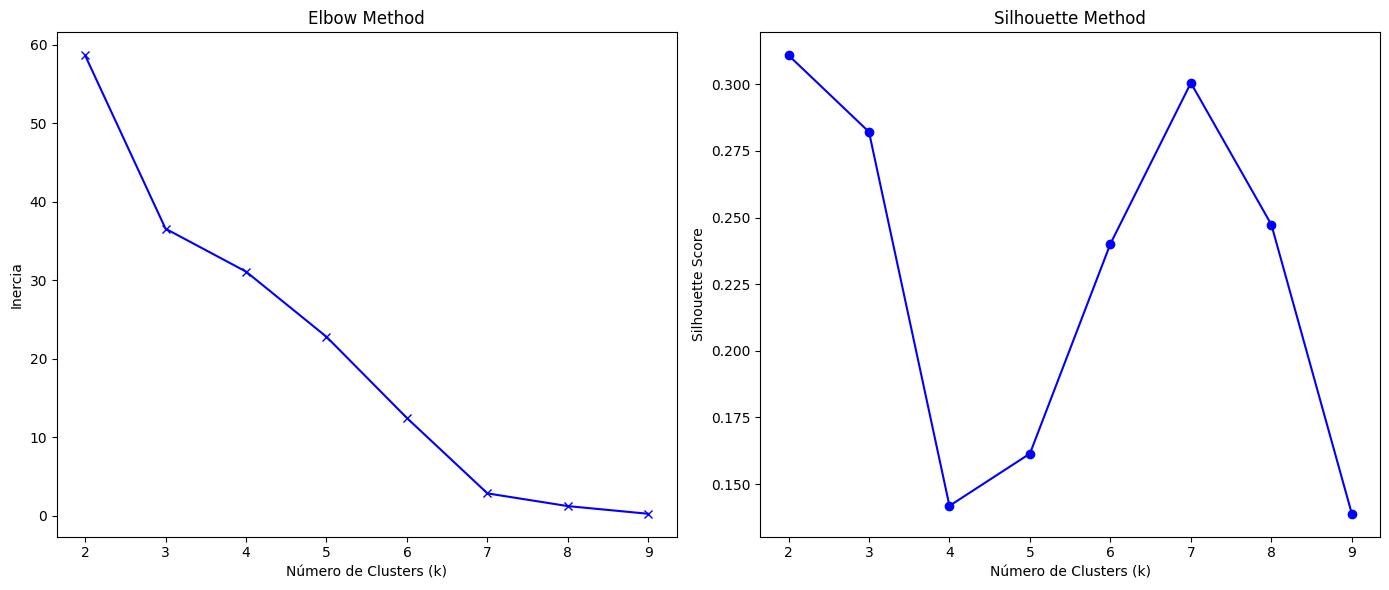

In [15]:
km_m.plot_elbow_silhouette(scaled_df, 9)

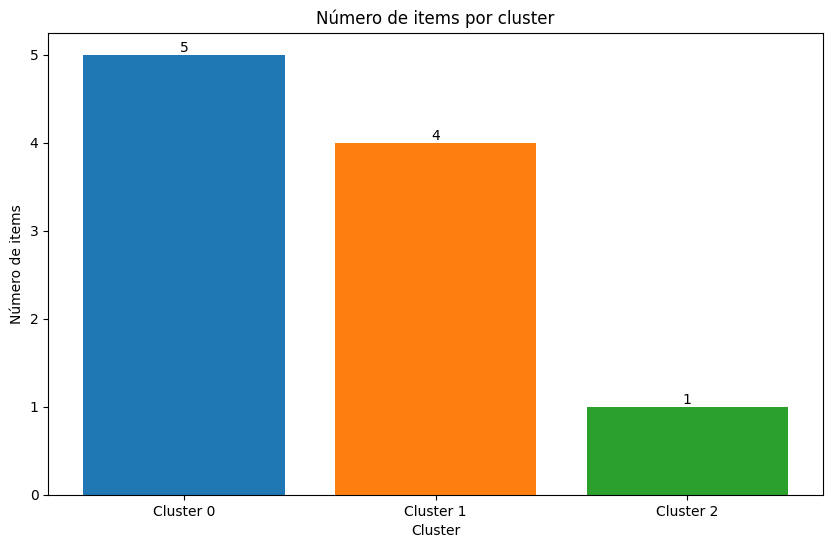

,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),SUM(sales.units),Cluster
store_code,,,,,,,,,,,
NYC_1,938.232,260.0,12.834098,3.387492,0.0665,1.0,18.205904,5.175719,1.398949e+07,3692451.0,1
NYC_2,458.451,185.0,11.375500,2.885454,0.2400,1.0,13.294661,3.883417,1.066557e+07,2705376.0,0
NYC_3,1508.520,376.0,16.051698,4.298816,0.2400,1.0,24.534254,7.476576,1.985736e+07,5318014.0,2
NYC_4,465.000,300.0,9.227017,2.388501,0.2400,1.0,10.458066,2.813298,7.778800e+06,2013616.0,0
BOS_1,575.424,323.0,11.165976,3.031962,0.0600,1.0,14.811843,4.657049,9.671119e+06,2626055.0,0


In [16]:
optimal_k = 3

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

Analisis

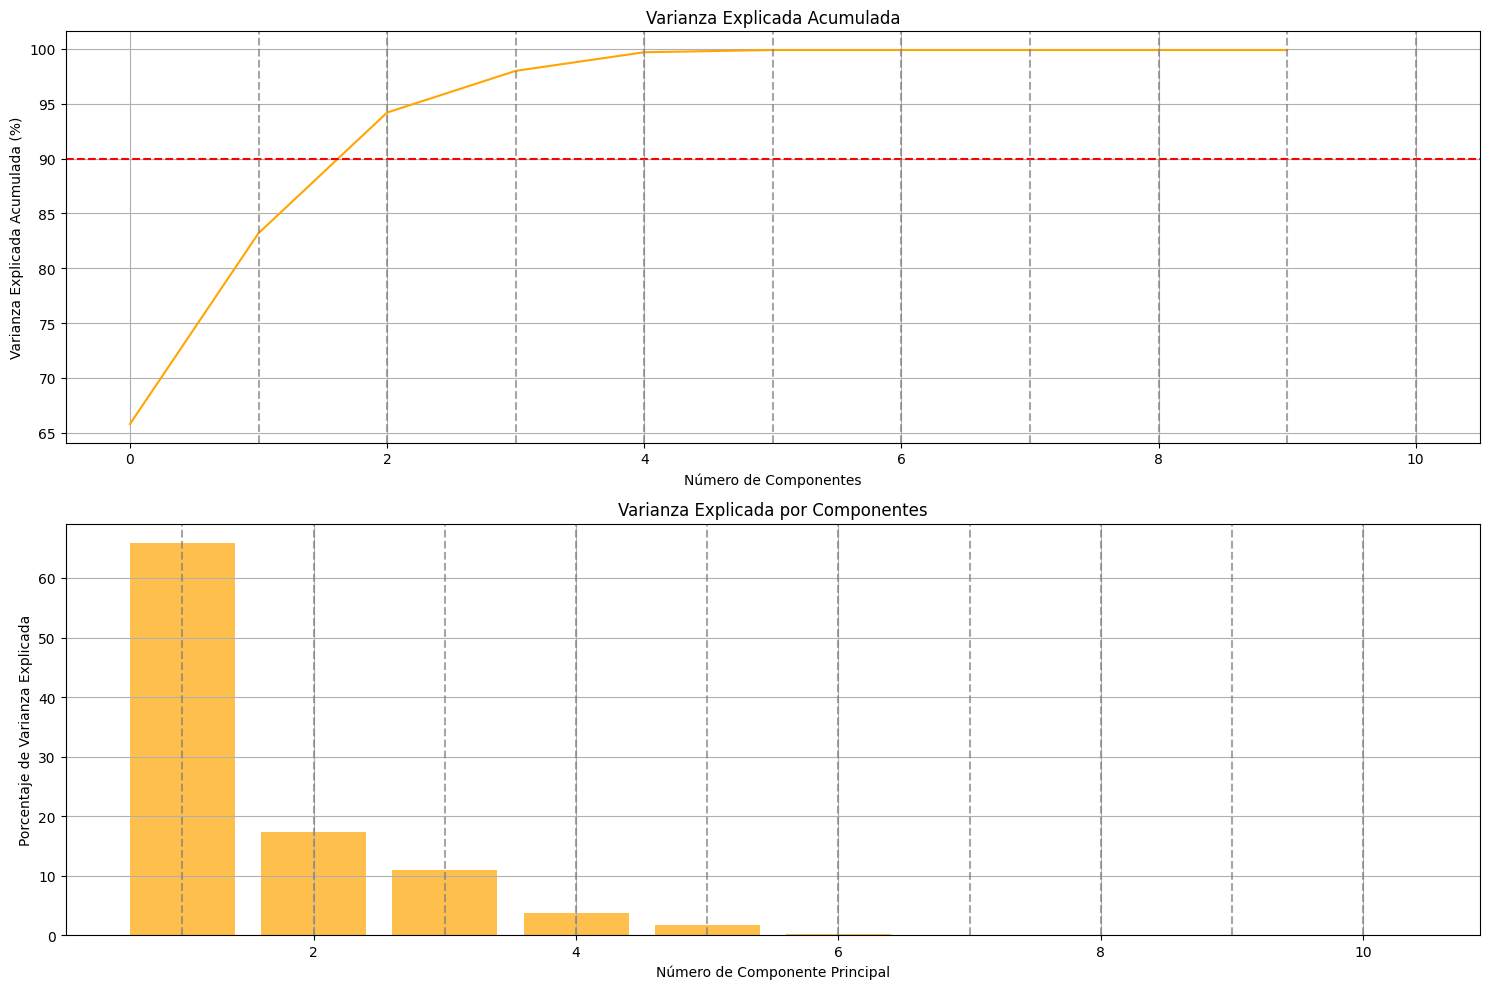

Varianza explicada por cada componente (%): [65.8 17.4 11.   3.8  1.7  0.2  0.   0.   0.   0. ]


,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6,Componente 7,Componente 8,Componente 9,Componente 10
0,65.8,83.2,94.2,98.0,99.7,99.9,99.9,99.9,99.9,99.9


In [17]:
# Vemos varianza acumulada en componentes principales
variance_ratio = km_m.view_pca_variance(scaled_df)

acc_var = km_m.calculate_accumulated_variance(variance_ratio)

display(acc_var)

Importancia caracteristicas

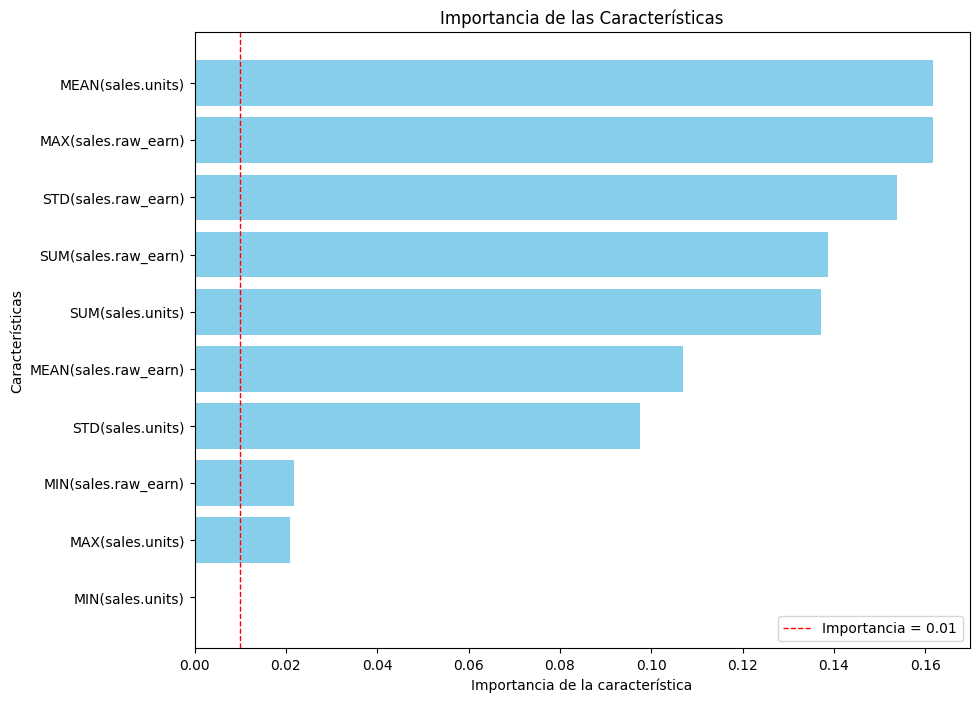

In [19]:
# Importancia de caracteristicas
# Preprocesamos datos
cluster_col='Cluster'
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([scaled_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.01
importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

# Seleccionamos solo las caracteristicas que tienen importancia por encima o igual del umbral
selected_features = importance_df[importance_df['Importance'] >= IMPORTANCE_THRES]

# Creamos una lista con las features más importantes usando la columna feature de importance_df
most_important_features = selected_features['Feature'].tolist()

# display(importance_df.head(10))

## Dim redux

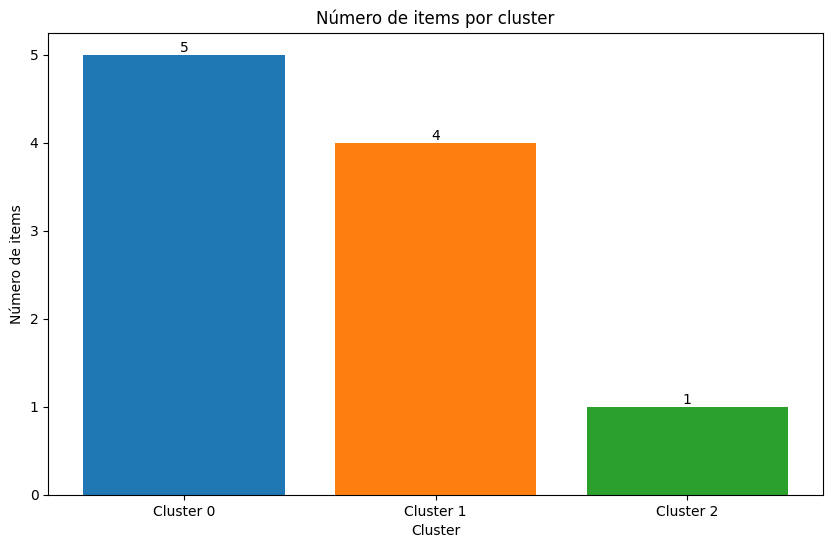

In [20]:
# Ejecutar PCA y clustering
n_components = 3 # Segun visto en varianza acumulada -> +90%

# Obtenemos scaled df con componentes y clusters
df_with_pca, loadings_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# # Mostrar el DataFrame con PCA y clustering
# display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

## Descripcion de clusters

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


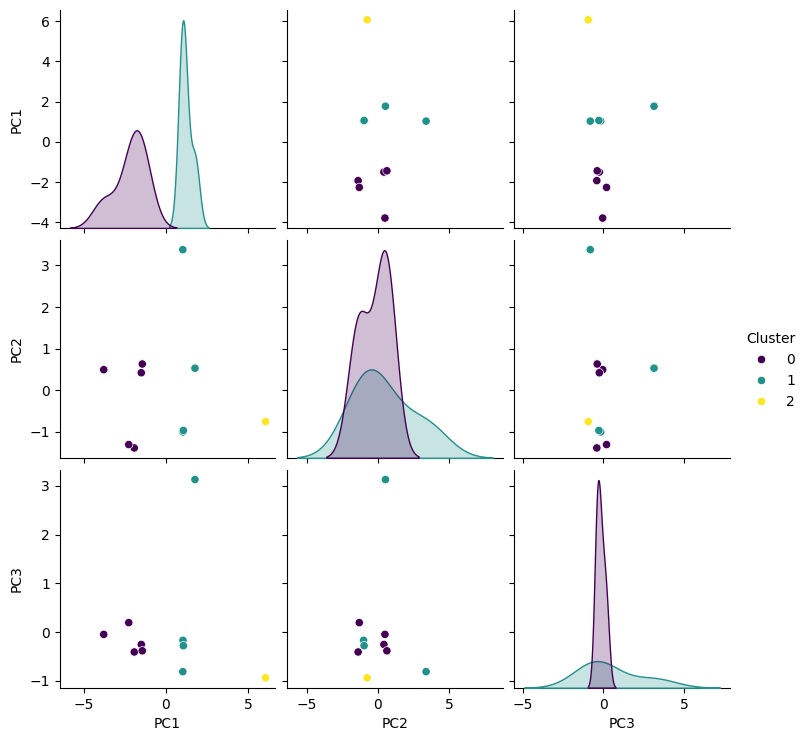

In [21]:
# Visualizacion clusters
cols = n_components + 1 # -> Seleccionamos solo las columnas de PC + Cluster
df_pairplot = df_with_pca.iloc[:, -(cols):]

df_pairplot['Cluster'] = df_with_pca['Cluster']
sns.pairplot(df_pairplot[0:], hue='Cluster', palette='viridis')

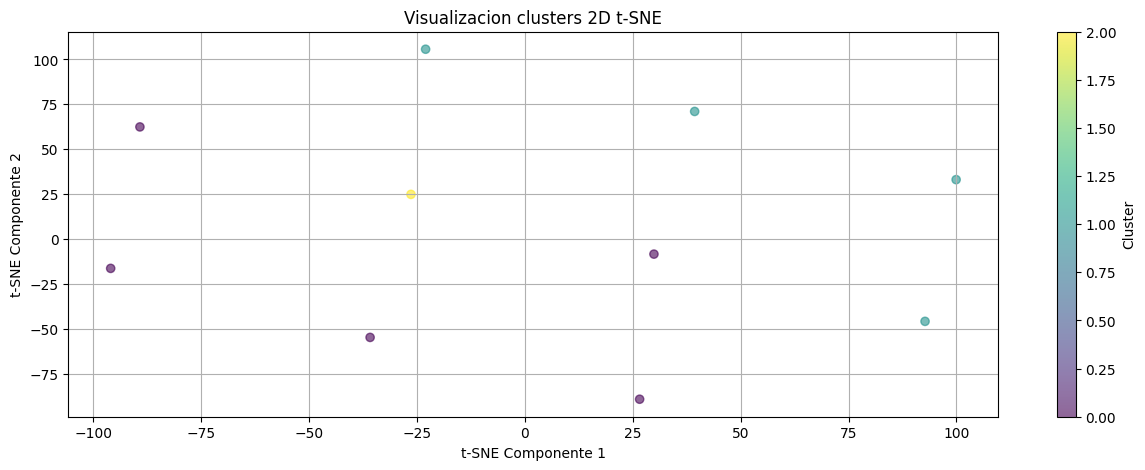

In [22]:
# T SNE visualizacion de clusters
km_m.tsne_visualization(df_pairplot, n_components=2, perplexity=9)

**Analisis**  
  
Mejor con 3 optimal_k que con 6 optimal_k

In [23]:
# Seleccionamos las features según la lista most_important_features obtenida con random forest
importance_df_filt = importance_df[importance_df['Feature'].isin(most_important_features)]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
# Ordenamos columnas de description_df usando sort
description_df = description_df[sorted(description_df.columns)]
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,1,2
MEAN(sales.units),-0.834099,0.447878,2.497592
MAX(sales.raw_earn),-0.539386,1.154449,1.902549
STD(sales.raw_earn),-0.622981,0.769654,1.315524
SUM(sales.raw_earn),-0.744847,0.545040,3.814146
SUM(sales.units),-0.471138,0.547642,3.126278
MEAN(sales.raw_earn),-0.644469,0.441369,2.189033
STD(sales.units),-0.719853,0.261142,1.329404
MIN(sales.raw_earn),0.131000,-0.010833,0.978333
MAX(sales.units),-0.545566,0.593272,0.807339


In [24]:
# Añadimos clusters a df_items
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,1
1,NYC_2,New York,Harlem,0
2,NYC_3,New York,Tribeca,2
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,0


In [25]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Tiendas con bajo rendimiento en ventas',
        'description': 'Este grupo incluye tiendas con un bajo rendimiento en ventas, con métricas negativas en cuanto a ingresos brutos, unidades vendidas y la variabilidad de estas. Estas tiendas tienen un desempeño inferior, lo que podría deberse a una baja demanda o una oferta menos atractiva.'
    },
    1: {
        'cluster_name': 'Tiendas con rendimiento promedio en ventas',
        'description': 'Las tiendas en este cluster muestran un rendimiento moderado en términos de ventas y unidades vendidas. Las métricas de ingresos y unidades vendidas están en niveles cercanos al promedio, lo que sugiere que estas tiendas tienen un rendimiento estable pero no sobresaliente en comparación con el resto.'
    },
    2: {
        'cluster_name': 'Tiendas con alto rendimiento en ventas',
        'description': 'Este grupo está formado por tiendas con un alto rendimiento en ventas. Las métricas de ingresos y unidades vendidas son significativamente superiores, y aunque presentan cierta variabilidad, estas tiendas sobresalen por sus ventas elevadas y su capacidad de generar ingresos de manera consistente.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

shops_with_cluster_info = shops_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `shops_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,cluster,cluster_name,description
0,NYC_1,New York,Greenwich_Village,1,Tiendas con rendimiento promedio en ventas,Las tiendas en este cluster muestran un rendim...
1,NYC_2,New York,Harlem,0,Tiendas con bajo rendimiento en ventas,Este grupo incluye tiendas con un bajo rendimi...
2,NYC_3,New York,Tribeca,2,Tiendas con alto rendimiento en ventas,Este grupo está formado por tiendas con un alt...
3,NYC_4,New York,Brooklyn,0,Tiendas con bajo rendimiento en ventas,Este grupo incluye tiendas con un bajo rendimi...
4,BOS_1,Boston,South_End,0,Tiendas con bajo rendimiento en ventas,Este grupo incluye tiendas con un bajo rendimi...


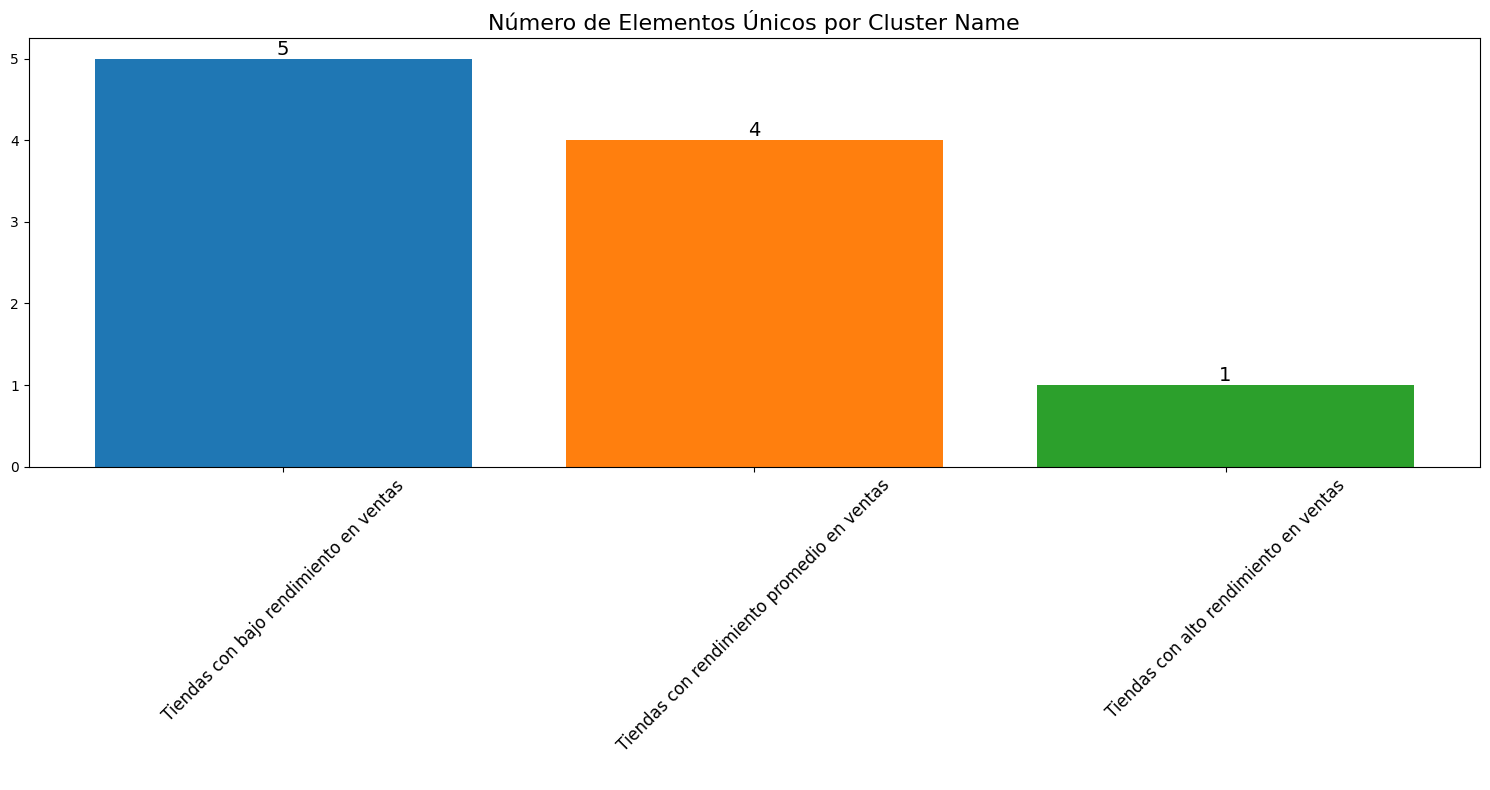

In [26]:
km_m.plot_clusters_with_name(shops_with_cluster_info)

## Guardar CSV

In [27]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_global_sales_performance.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
shops_with_cluster_info.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **MIX DE PRODUCTOS: Segun cluster performance ventas global**  
  
Esta configuración se centra en entender la variedad y popularidad de los productos en diferentes tiendas.
___
___

## Importacion de datos

In [28]:
# Cargamos df de items con segmentacion segun ventas diarias de 2014 a 2016 de estos
df_items_sp_clusters = get_data('_clusters/items_clusters_raw_earn.csv')

In [29]:
display(df_items_sp_clusters.head())
display(df_shops.head())
display(df_ws.head())

,item,category,department,Cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,Productos con bajo rendimiento,Este grupo incluye productos con bajos ingreso...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0,Productos con bajo rendimiento,Este grupo incluye productos con bajos ingreso...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0,Productos con bajo rendimiento,Este grupo incluye productos con bajos ingreso...
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,3,Productos con rendimiento superior pero con va...,Los productos de este cluster muestran un alto...
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0,Productos con bajo rendimiento,Este grupo incluye productos con bajos ingreso...


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,id,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number
0,0,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2
1,1,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2
2,2,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2
3,3,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2
4,4,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2


In [30]:
# ONE HOT ENCODING DE LOS CLUSTERS - PARA EVITAR CREAR CARACTERISTICAS NUMERICAS BASADAS EN ELLOS
# Guardamos los nombres y definiciones de los clusters aparte para trabajar solo con la columna Cluster de productos
# Crear el diccionario de nombres y descripciones de clusters
cluster_dict = df_items_sp_clusters[['Cluster', 'cluster_name', 'description']].drop_duplicates().set_index('Cluster').to_dict('index')

df_items_ohe = df_items_sp_clusters.copy()

# Hacer OHE usando scikit learn
from sklearn.preprocessing import OneHotEncoder
df_items_ohe = df_items_ohe.drop(columns=['Cluster', 'description'])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_items_ohe = ohe.fit_transform(df_items_ohe[['cluster_name']])
df_items_ohe = pd.DataFrame(df_items_ohe, columns=ohe.get_feature_names_out(['cluster_name']))
df_items_ohe = pd.concat([df_items_sp_clusters[['item']], df_items_ohe], axis=1)

# display(df_items_ohe.head())

## Seleccion / Creacion caracteristicas

In [31]:
# Creacion caracteristicas globales para tiendas (luego iremos filtrando)
fc_config = {
    'target_df': 'shops',  # El DataFrame que contiene información sobre las tiendas
    'agg_primitives': [
        'mean',              # Promedio
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        'percentile'
    ],
    'max_depth': 2  # Profundidad máxima de las características generadas
}

feature_matrix, feature_defs = fcm.create_features(df_items_ohe, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [33]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(features_descriptions)

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.month)>: The average of the "month" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.units)>: The average of the "units" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.week)>: The average of the "week" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.weekday_number)>: The average of the "weekday_number" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.year)>: The average of the "year" of all instances of "sales" for each "store_code" in "shops".',
 '<Feat

## Seleccion caracteristicas

In [34]:
substrings = substrings = [
    'items',
    'units',
    'raw_earn',
    'sell_price',
    'cluster_name'
]

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 28
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 28
Shape after filtering: 13
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MEAN(sales.raw_earn),MEAN(sales.sell_price),SUM(sales.sell_price),MEAN(sales.items.cluster_name_Productos con bajo rendimiento),MEAN(sales.items.cluster_name_Productos con rendimiento intermedio),MEAN(sales.items.cluster_name_Productos con rendimiento superior pero con variabilidad),MEAN(sales.items.cluster_name_Productos de alto rendimiento),SUM(sales.items.cluster_name_Productos con rendimiento moderado),SUM(sales.items.cluster_name_Productos de alto rendimiento),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.sell_price))
store_code,,,,,,,,,,,,,
NYC_1,12.834098,4.983181,5.431792e+06,0.542355,0.250760,0.171196,0.002062,36653.0,2248.0,0.8,0.8,0.9,0.9
NYC_2,11.375500,5.005206,4.692836e+06,0.530387,0.257044,0.173232,0.002298,34727.0,2155.0,0.5,0.3,0.5,0.6
NYC_3,16.051698,5.005455,6.192188e+06,0.545027,0.242798,0.176549,0.002246,41294.0,2779.0,1.0,1.0,1.0,1.0
NYC_4,9.227017,4.840426,4.080702e+06,0.511759,0.275462,0.171147,0.002089,33337.0,1761.0,0.1,0.1,0.1,0.2
BOS_1,11.165976,4.802672,4.159710e+06,0.492223,0.283357,0.178420,0.002873,37354.0,2488.0,0.4,0.4,0.3,0.3


## Preprocesamiento datos

In [35]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 13


## Kmeans

Elbow & Silhoutte

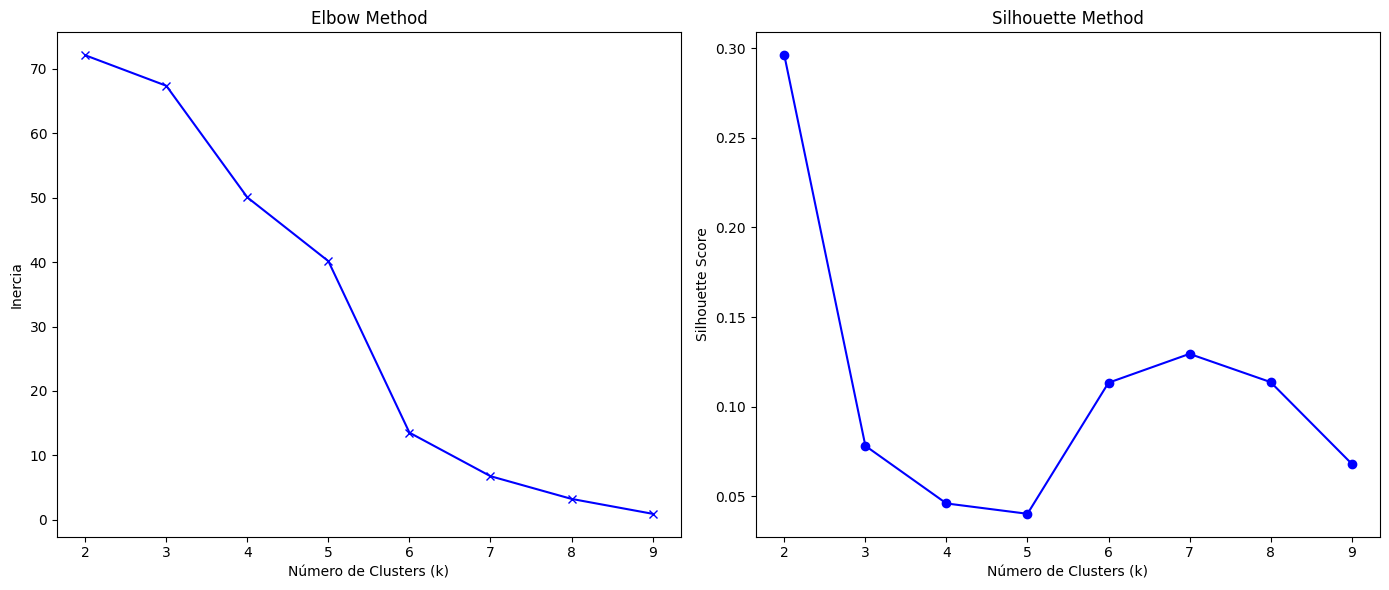

In [36]:
km_m.plot_elbow_silhouette(scaled_df, 9)

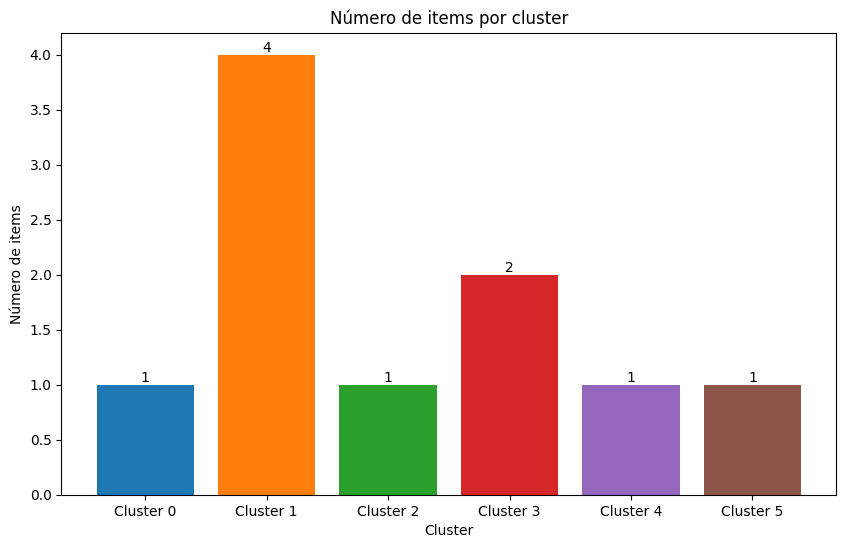

,MEAN(sales.raw_earn),MEAN(sales.sell_price),SUM(sales.sell_price),MEAN(sales.items.cluster_name_Productos con bajo rendimiento),MEAN(sales.items.cluster_name_Productos con rendimiento intermedio),MEAN(sales.items.cluster_name_Productos con rendimiento superior pero con variabilidad),MEAN(sales.items.cluster_name_Productos de alto rendimiento),SUM(sales.items.cluster_name_Productos con rendimiento moderado),SUM(sales.items.cluster_name_Productos de alto rendimiento),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.sell_price)),Cluster
store_code,,,,,,,,,,,,,,
NYC_1,12.834098,4.983181,5.431792e+06,0.542355,0.250760,0.171196,0.002062,36653.0,2248.0,0.8,0.8,0.9,0.9,1
NYC_2,11.375500,5.005206,4.692836e+06,0.530387,0.257044,0.173232,0.002298,34727.0,2155.0,0.5,0.3,0.5,0.6,2
NYC_3,16.051698,5.005455,6.192188e+06,0.545027,0.242798,0.176549,0.002246,41294.0,2779.0,1.0,1.0,1.0,1.0,5
NYC_4,9.227017,4.840426,4.080702e+06,0.511759,0.275462,0.171147,0.002089,33337.0,1761.0,0.1,0.1,0.1,0.2,0
BOS_1,11.165976,4.802672,4.159710e+06,0.492223,0.283357,0.178420,0.002873,37354.0,2488.0,0.4,0.4,0.3,0.3,3


In [37]:
optimal_k = 6 # 6 o 3 -> Con 6 quedan varios clusters de una tienda

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

Analisis

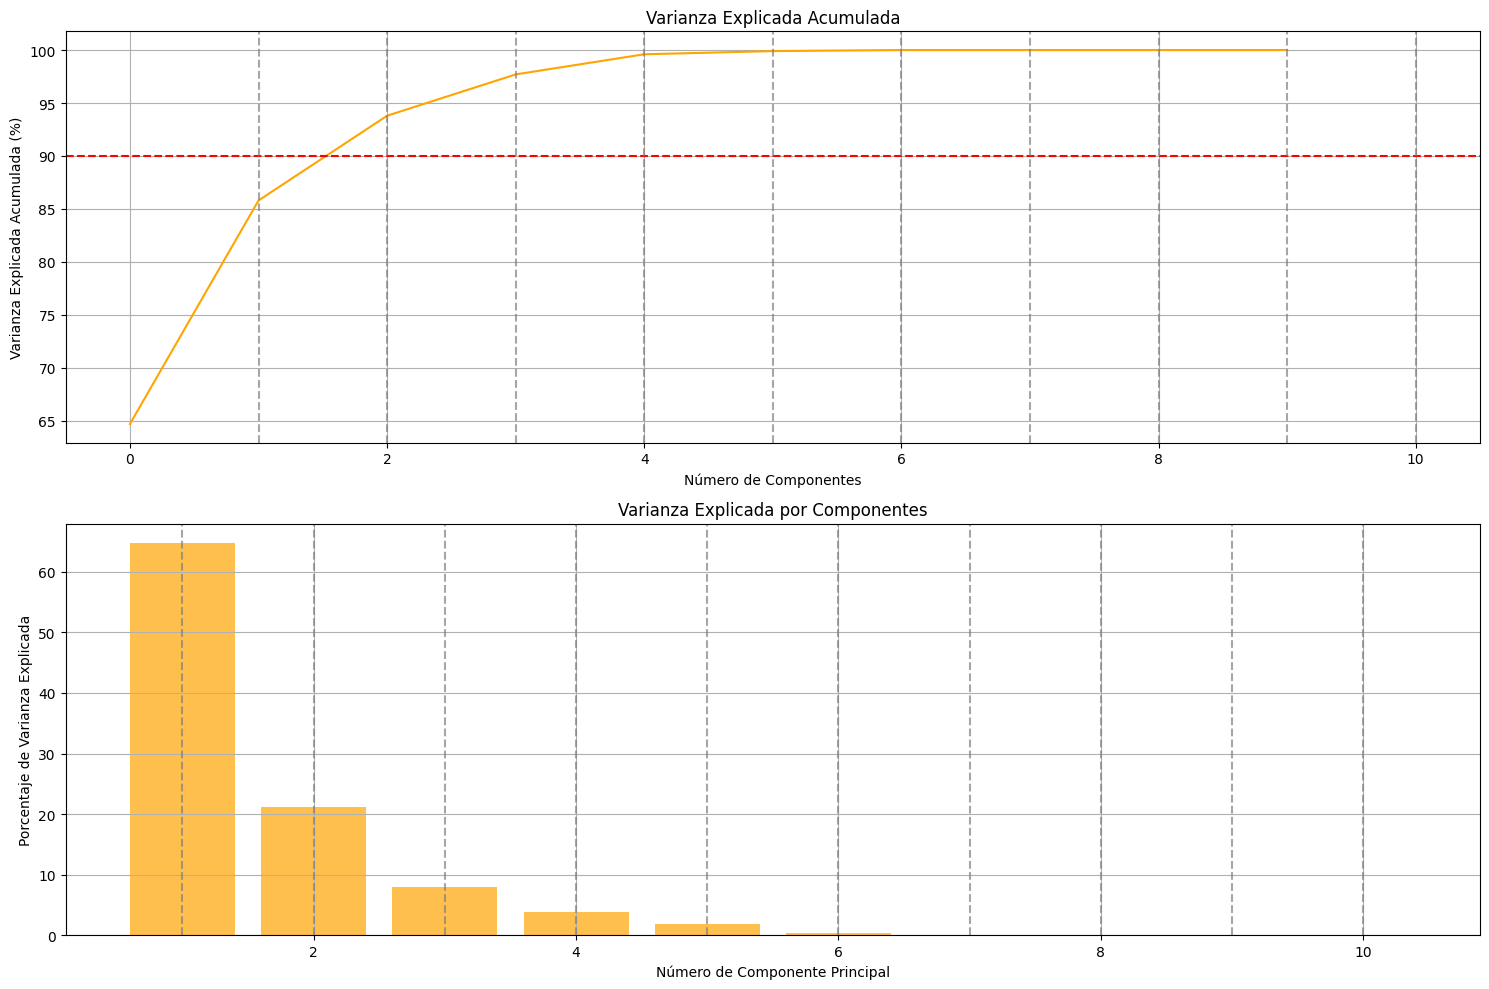

Varianza explicada por cada componente (%): [64.7 21.1  8.   3.9  1.9  0.3  0.1  0.   0.   0. ]


,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6,Componente 7,Componente 8,Componente 9,Componente 10
0,64.7,85.8,93.8,97.7,99.6,99.9,100.0,100.0,100.0,100.0


In [38]:
# Vemos varianza acumulada en componentes principales
variance_ratio = km_m.view_pca_variance(scaled_df)

acc_var = km_m.calculate_accumulated_variance(variance_ratio)

display(acc_var)

Importancia caracteristicas

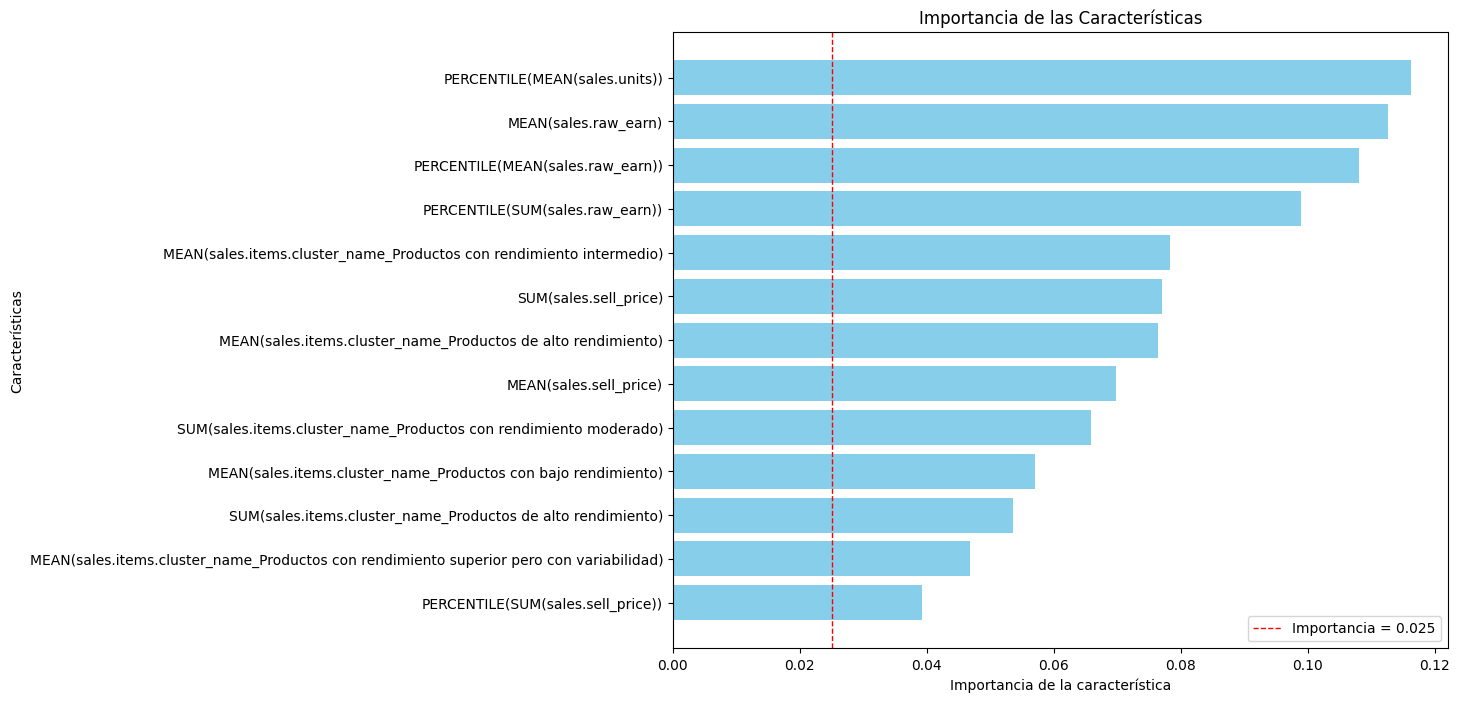

In [40]:
# Importancia de caracteristicas
# Preprocesamos datos
cluster_col='Cluster'
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([scaled_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.025
importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

# Seleccionamos solo las caracteristicas que tienen importancia por encima o igual del umbral
selected_features = importance_df[importance_df['Importance'] >= IMPORTANCE_THRES]

# Creamos una lista con las features más importantes usando la columna feature de importance_df
most_important_features = selected_features['Feature'].tolist()

# display(importance_df.head(10))

## Dim redux

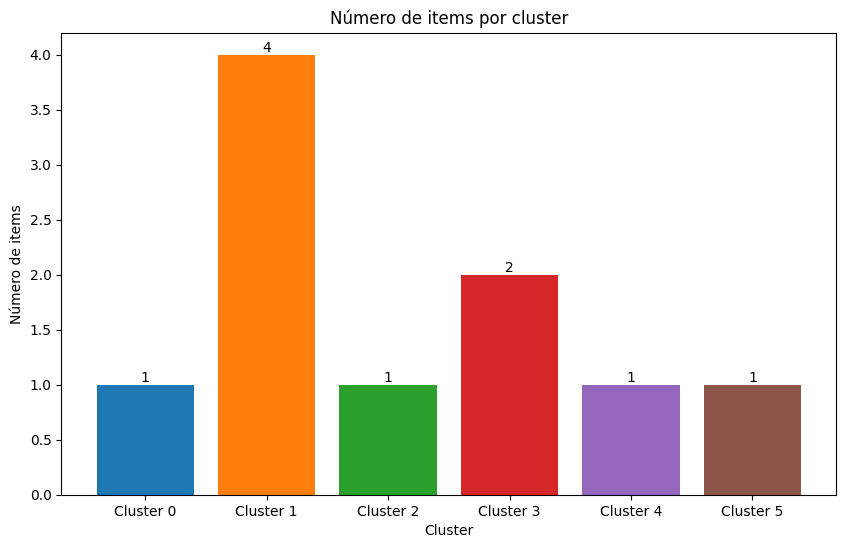

In [44]:
# Ejecutar PCA y clustering
n_components = 3 # Segun visto en varianza acumulada -> casi 95%

# Obtenemos scaled df con componentes y clusters
df_with_pca, loadings_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# # Mostrar el DataFrame con PCA y clustering
# display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

## Descripcion de clusters

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


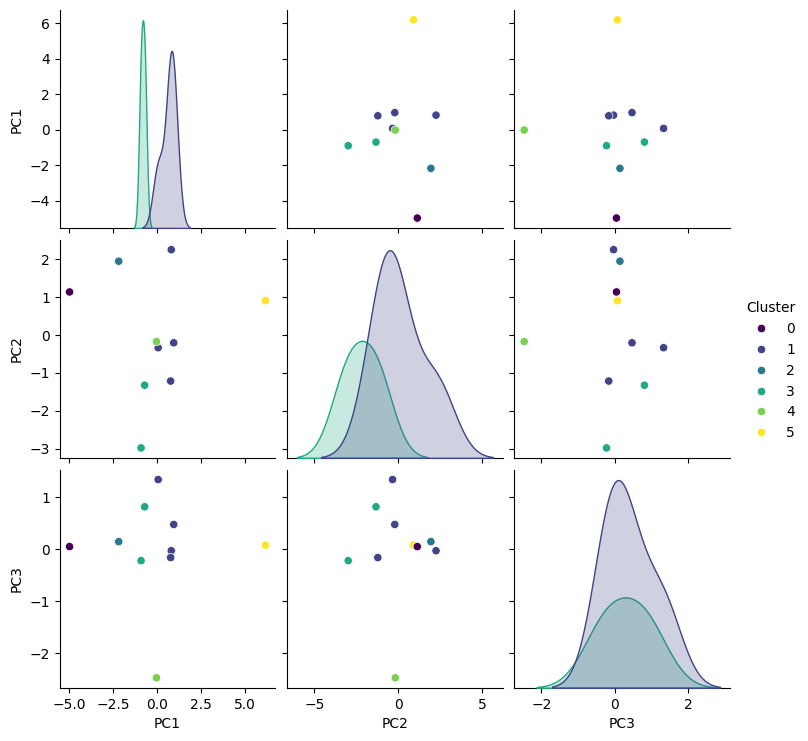

In [45]:
# Visualizacion clusters
cols = n_components + 1 # -> Seleccionamos solo las columnas de PC + Cluster
df_pairplot = df_with_pca.iloc[:, -(cols):]

df_pairplot['Cluster'] = df_with_pca['Cluster']
sns.pairplot(df_pairplot[0:], hue='Cluster', palette='viridis')

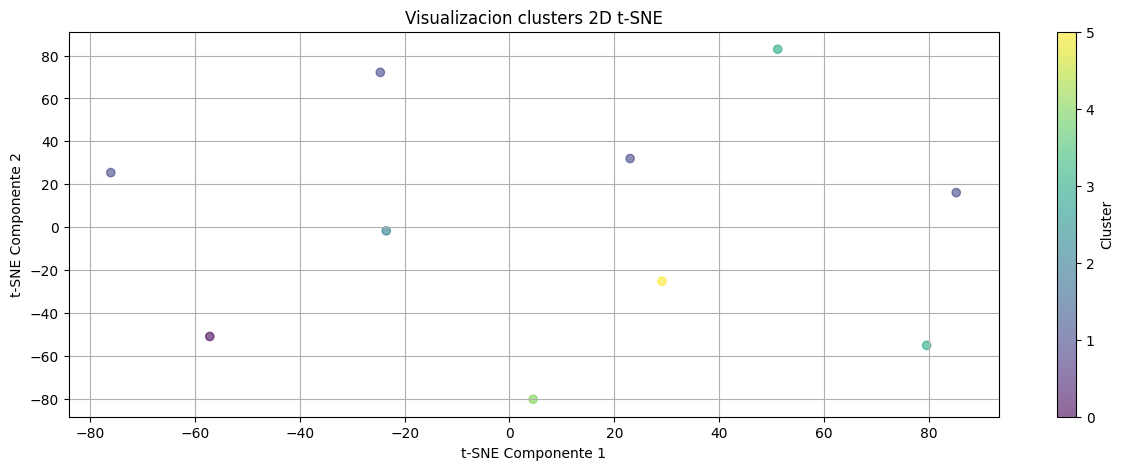

In [47]:
# T SNE visualizacion de clusters
km_m.tsne_visualization(df_pairplot, n_components=2, perplexity=9)

**Analisis**  
  
No parece aportar mucho esta segmentacion. Demasiados clusters de un unico elemento.

In [48]:
# Seleccionamos las features según la lista most_important_features obtenida con random forest
importance_df_filt = importance_df[importance_df['Feature'].isin(most_important_features)]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
# Ordenamos columnas de description_df usando sort
description_df = description_df[sorted(description_df.columns)]
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,1,2,3,4,5
PERCENTILE(MEAN(sales.units)),-1.000000,0.444444,-0.555556,-0.222222,-0.777778,1.000000
MEAN(sales.raw_earn),-1.316980,0.441369,-0.213249,-0.427595,-0.836926,2.189033
PERCENTILE(MEAN(sales.raw_earn)),-1.000000,0.444444,-0.111111,-0.444444,-0.777778,1.000000
PERCENTILE(SUM(sales.raw_earn)),-1.000000,0.444444,-0.111111,-0.666667,-0.333333,1.000000
MEAN(sales.items.cluster_name_Productos con rendimiento intermedio),0.350379,-0.147720,-0.533309,1.007992,-0.723882,-1.216839
SUM(sales.sell_price),-0.910138,0.269101,0.139151,-1.054124,0.361761,2.709265
MEAN(sales.items.cluster_name_Productos de alto rendimiento),-0.930701,-0.017139,-0.646694,0.362530,-0.131281,-0.717210
MEAN(sales.sell_price),-0.087276,-0.083919,0.619296,-0.844913,-0.684003,0.620363
SUM(sales.items.cluster_name_Productos con rendimiento moderado),-4.423478,-0.166484,-2.898519,0.149205,0.016456,4.306089
MEAN(sales.items.cluster_name_Productos con bajo rendimiento),-0.274441,-0.002290,0.243218,-0.752443,1.000456,0.650040


In [49]:
# Añadimos clusters a df_items
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,1
1,NYC_2,New York,Harlem,2
2,NYC_3,New York,Tribeca,5
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,3


In [50]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Tiendas con ventas bajas y productos de bajo rendimiento',
        'description': 'Este grupo incluye tiendas que ofrecen principalmente productos con bajo rendimiento de ventas. Las ganancias y los volúmenes de ventas son significativamente inferiores, lo que refleja una baja demanda o una mezcla de productos poco atractiva para los clientes.'
    },
    1: {
        'cluster_name': 'Tiendas con productos de rendimiento intermedio',
        'description': 'Las tiendas en este cluster manejan un mix de productos que tienen un rendimiento de ventas intermedio. Aunque no destacan por ingresos altos, su mezcla de productos permite mantener ventas moderadas y una mayor estabilidad en el mercado.'
    },
    2: {
        'cluster_name': 'Tiendas con ventas moderadas y productos variables',
        'description': 'Este cluster representa tiendas con ventas moderadas que manejan una variedad de productos con rendimientos mixtos, lo que incluye tanto productos de bajo rendimiento como algunos de rendimiento superior pero con variabilidad en las ventas.'
    },
    3: {
        'cluster_name': 'Tiendas con un mix de productos de alto rendimiento',
        'description': 'Estas tiendas cuentan con una mezcla de productos que tienen un alto rendimiento en ventas. A pesar de tener una menor cantidad de productos, generan ingresos significativos debido al alto rendimiento de su portafolio.'
    },
    4: {
        'cluster_name': 'Tiendas con productos de alto valor y ventas moderadas',
        'description': 'Este grupo se caracteriza por manejar productos de mayor valor en términos de precio, aunque con ventas moderadas. Las tiendas de este cluster generan ingresos relativamente buenos debido al valor de los productos, aunque las unidades vendidas no son tan altas.'
    },
    5: {
        'cluster_name': 'Tiendas con un mix de productos con alto rendimiento en ventas',
        'description': 'Este cluster incluye tiendas que manejan una combinación de productos con muy alto rendimiento en ventas. Estas tiendas tienen una mezcla de productos que les permite destacar en el mercado, generando tanto altos ingresos como una alta rotación de unidades.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

shops_with_cluster_info = shops_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `shops_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,cluster,cluster_name,description
0,NYC_1,New York,Greenwich_Village,1,Tiendas con productos de rendimiento intermedio,Las tiendas en este cluster manejan un mix de ...
1,NYC_2,New York,Harlem,2,Tiendas con ventas moderadas y productos varia...,Este cluster representa tiendas con ventas mod...
2,NYC_3,New York,Tribeca,5,Tiendas con un mix de productos con alto rendi...,Este cluster incluye tiendas que manejan una c...
3,NYC_4,New York,Brooklyn,0,Tiendas con ventas bajas y productos de bajo r...,Este grupo incluye tiendas que ofrecen princip...
4,BOS_1,Boston,South_End,3,Tiendas con un mix de productos de alto rendim...,Estas tiendas cuentan con una mezcla de produc...


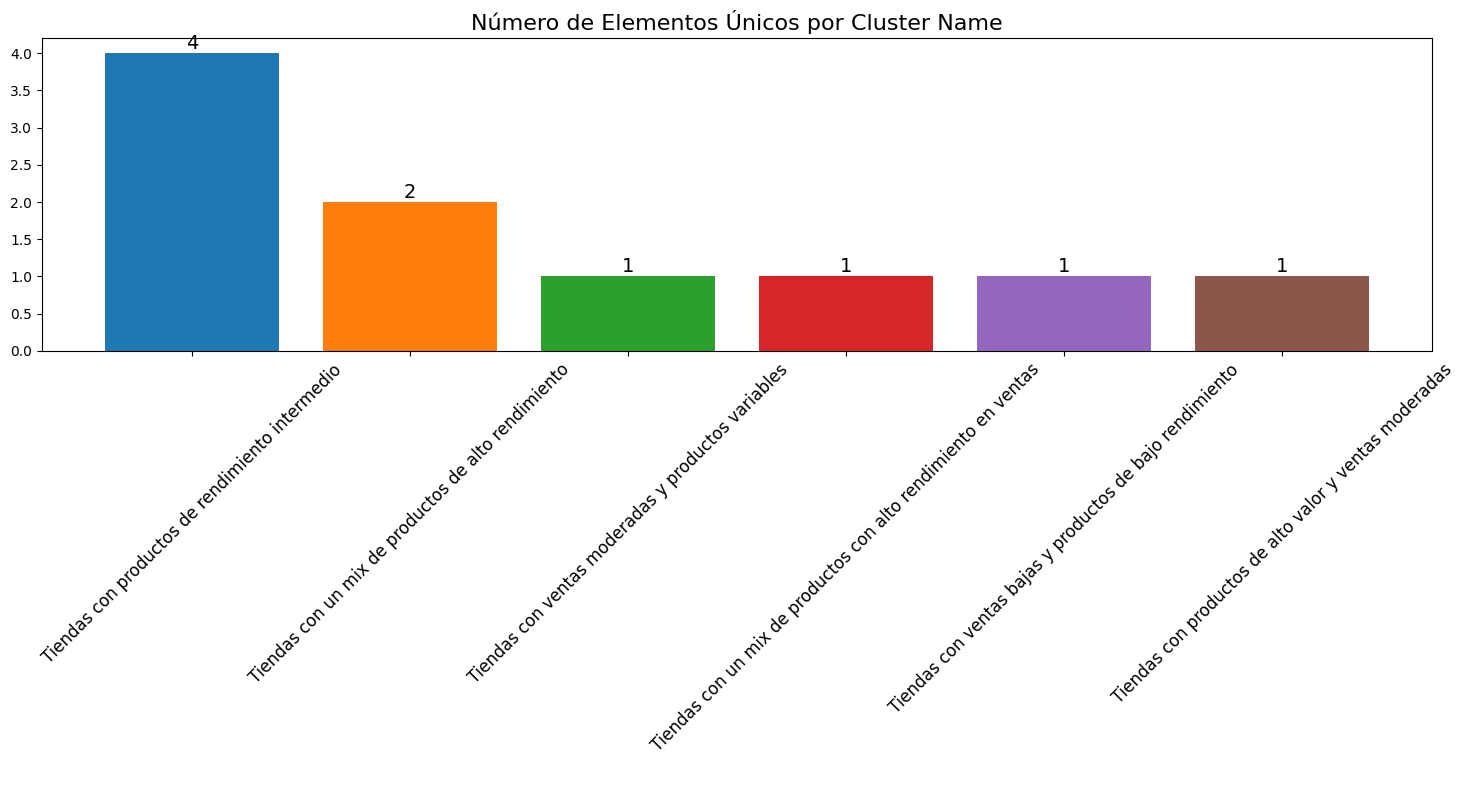

In [51]:
km_m.plot_clusters_with_name(shops_with_cluster_info)

## Guardar CSV

In [52]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_products_mix.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
shops_with_cluster_info.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **TIENDAS: SALES w EVENTS**
___
___

In [53]:
# Recuperamos full df con eventos
df_ws = get_data('daily_sales_with_events.csv')

# Seleccionar solo años 2014 a 2016 de df_ws
df_ws = df_ws[(df_ws['year'] >= 2014) & (df_ws['year'] <= 2016)]

# Cambiamos NaN de event por None
df_ws['event'] = df_ws['event'].fillna('None')

display(df_ws.shape)

/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering/modules/get_data.py:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


(9693001, 12)

## Creacion caracteristicas

In [55]:
# OHE para columna event en df_ws usando sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Seleccionar la columna 'event' para codificar
events = df_ws[['event']]

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar los eventos con OHE
event_encoded = ohe.fit_transform(events)

# Crear un DataFrame con las columnas codificadas
event_encoded_df = pd.DataFrame(event_encoded, columns=ohe.get_feature_names_out(['event']))

# Concatenar con el DataFrame original de ventas
df_ws_ohe = pd.concat([df_ws.reset_index(drop=True), event_encoded_df], axis=1)

# Eliminamos columna event original
df_ws_ohe = df_ws_ohe.drop(columns=['event'])

In [56]:
import featuretools as ft

# Crear un EntitySet
es = ft.EntitySet(id='sales_data')

# Agregar entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_ohe, index="id",
                      time_index="week",)
                      # secondary_time_index={'year': ['units', 'sell_price', 'raw_earn']})

# Definir relaciones
es = es.add_relationship("items", "item", "sales", "item")
es = es.add_relationship("shops", "store_code", "sales", "store_code")

# Generar características automáticas, ahora centradas en "items"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="shops",  # Objetivo: productos
                                      agg_primitives=[
                                          'min',               # Mínimo
                                          'max',               # Máximo
                                          'mean',              # Promedio
                                          'std',               # Desviación estándar
                                          'sum',               # Suma
                                          'count'              # Totales
                                      ],
                                      trans_primitives=[
                                          # Month no hace falta ya lo tenemos en esta iteracion
                                          # 'month',  # Extrae el mes para observar patrones estacionales a nivel semanal
                                          'is_weekend'  # Indica si la semana incluye fines de semana
                                      ],
                                      max_depth=2)

feature_matrix.head(10)

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a f

,COUNT(sales),MAX(sales.event_Easter),MAX(sales.event_NewYear),MAX(sales.event_None),MAX(sales.event_Ramadan starts),MAX(sales.event_SuperBowl),MAX(sales.event_Thanksgiving),MAX(sales.month),MAX(sales.raw_earn),MAX(sales.sell_price),...,SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.month),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),SUM(sales.weekday_number),SUM(sales.year)
store_code,,,,,,,,,,,,,,,,,,,,,
NYC_1,1090025,1.0,1.0,1.0,1.0,1.0,1.0,12.0,938.2320,41.2034,...,2627.0,4027.0,1494.0,6536527.0,1.398949e+07,5.431792e+06,3692451.0,26712944.0,3406912.0,2.196112e+09
NYC_2,937591,1.0,1.0,1.0,1.0,1.0,1.0,12.0,458.4510,41.2034,...,2191.0,3485.0,1386.0,5639210.0,1.066557e+07,4.692836e+06,2705376.0,23102762.0,2983687.0,1.889057e+09
NYC_3,1237088,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1508.5200,41.2034,...,2853.0,4592.0,1979.0,7389990.0,1.985736e+07,6.192188e+06,5318014.0,30198468.0,3802844.0,2.492403e+09
NYC_4,843046,1.0,1.0,1.0,1.0,1.0,1.0,12.0,465.0000,41.2034,...,2085.0,3054.0,1266.0,5039905.0,7.778800e+06,4.080702e+06,2013616.0,20600848.0,2578568.0,1.698522e+09
BOS_1,866124,1.0,1.0,1.0,1.0,1.0,1.0,12.0,575.4240,60.9750,...,2048.0,3343.0,1611.0,5169496.0,9.671119e+06,4.159710e+06,2626055.0,21107029.0,2696036.0,1.745016e+09
BOS_2,968715,1.0,1.0,1.0,1.0,1.0,1.0,12.0,903.1680,38.5168,...,2282.0,3780.0,1620.0,5761347.0,1.182385e+07,4.728427e+06,3157231.0,23529447.0,3007827.0,1.951717e+09
BOS_3,926524,1.0,1.0,1.0,1.0,1.0,1.0,12.0,2152.4454,41.2034,...,2153.0,3620.0,1424.0,5530535.0,1.176832e+07,4.530480e+06,3014971.0,22593107.0,2852251.0,1.866712e+09
PHI_1,1025831,1.0,1.0,1.0,1.0,1.0,1.0,12.0,652.2120,44.8500,...,2469.0,3527.0,1281.0,6119481.0,1.042395e+07,4.822702e+06,2862559.0,25016547.0,3249663.0,2.066793e+09
PHI_2,950794,1.0,1.0,1.0,1.0,1.0,1.0,12.0,845.0640,42.7250,...,2107.0,3321.0,1289.0,5679410.0,1.222497e+07,4.383885e+06,3557537.0,23193088.0,2924072.0,1.915614e+09


In [58]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(features_descriptions)

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Easter)>: The maximum of the "event_Easter" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_NewYear)>: The maximum of the "event_NewYear" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_None)>: The maximum of the "event_None" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Ramadan starts)>: The maximum of the "event_Ramadan starts" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_SuperBowl)>: The maximum of the "event_SuperBowl" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Thanksgiving)>: The maximum of the "event_Thanksgiving" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.month)>: The maximum of the 

## Seleccion caracteristicas

In [59]:
# V3
substrings = ['raw_earn', 'units', 'event'] # Nos quedamos solo con las que afectan a ventas y eventos

print(f'Length All features: {len(features_descriptions)}')

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length All features: 66
Length Feats Selected: 40
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 40
Shape after filtering: 14
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving)
store_code,,,,,,,,,,,,,,
NYC_1,938.232,260.0,0.003587,0.002932,0.002410,0.003694,0.001371,12.834098,0.0665,18.205904,3910.0,3196.0,4027.0,1494.0
NYC_2,458.451,185.0,0.004198,0.003139,0.002337,0.003717,0.001478,11.375500,0.2400,13.294661,3936.0,2943.0,3485.0,1386.0
NYC_3,1508.520,376.0,0.003891,0.002963,0.002306,0.003712,0.001600,16.051698,0.2400,24.534254,4813.0,3666.0,4592.0,1979.0
NYC_4,465.000,300.0,0.003575,0.002632,0.002473,0.003623,0.001502,9.227017,0.2400,10.458066,3014.0,2219.0,3054.0,1266.0
BOS_1,575.424,323.0,0.004198,0.003052,0.002365,0.003860,0.001860,11.165976,0.0600,14.811843,3636.0,2643.0,3343.0,1611.0


## Preprocesamiento de los datos

In [60]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 14


## Kmeans

Elbow & Silouette

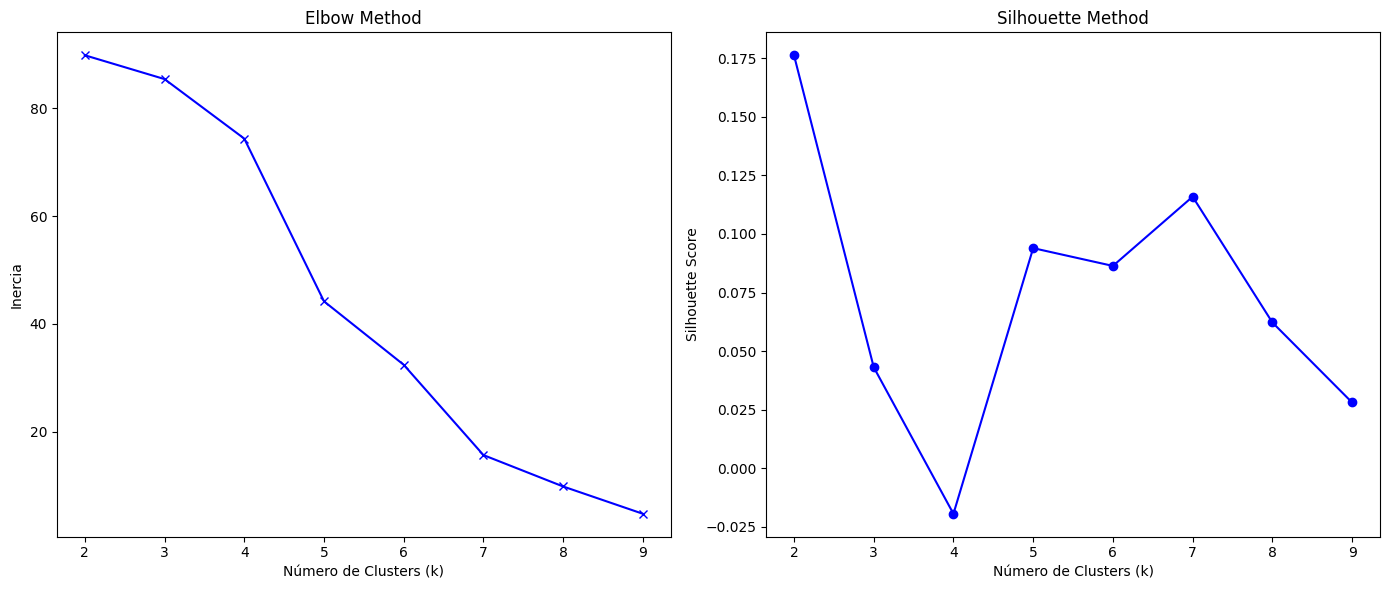

In [61]:
km_m.plot_elbow_silhouette(scaled_df, 9) # No podemos usar más de n_shops - 1

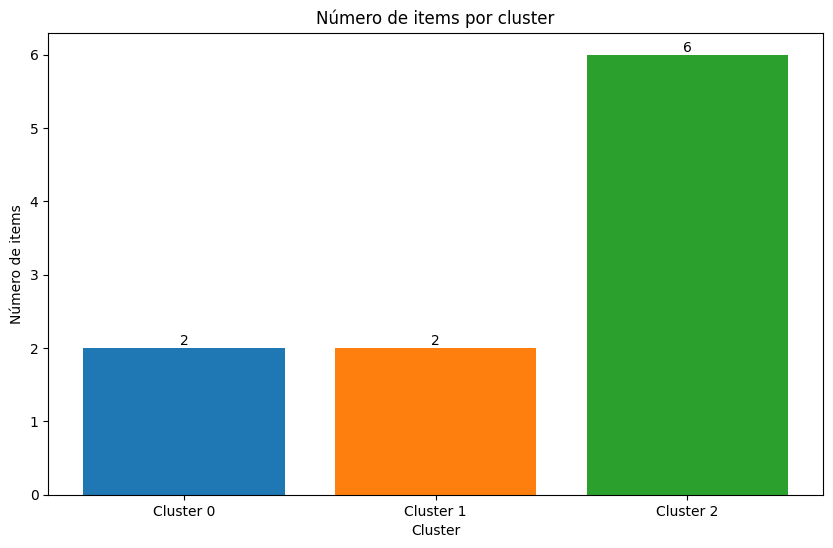

,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),Cluster
store_code,,,,,,,,,,,,,,,
NYC_1,938.232,260.0,0.003587,0.002932,0.002410,0.003694,0.001371,12.834098,0.0665,18.205904,3910.0,3196.0,4027.0,1494.0,2
NYC_2,458.451,185.0,0.004198,0.003139,0.002337,0.003717,0.001478,11.375500,0.2400,13.294661,3936.0,2943.0,3485.0,1386.0,2
NYC_3,1508.520,376.0,0.003891,0.002963,0.002306,0.003712,0.001600,16.051698,0.2400,24.534254,4813.0,3666.0,4592.0,1979.0,2
NYC_4,465.000,300.0,0.003575,0.002632,0.002473,0.003623,0.001502,9.227017,0.2400,10.458066,3014.0,2219.0,3054.0,1266.0,0
BOS_1,575.424,323.0,0.004198,0.003052,0.002365,0.003860,0.001860,11.165976,0.0600,14.811843,3636.0,2643.0,3343.0,1611.0,1


In [68]:
optimal_k = 3 # Probamos con 4 la primera iteracion

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

Analisis

PCAs

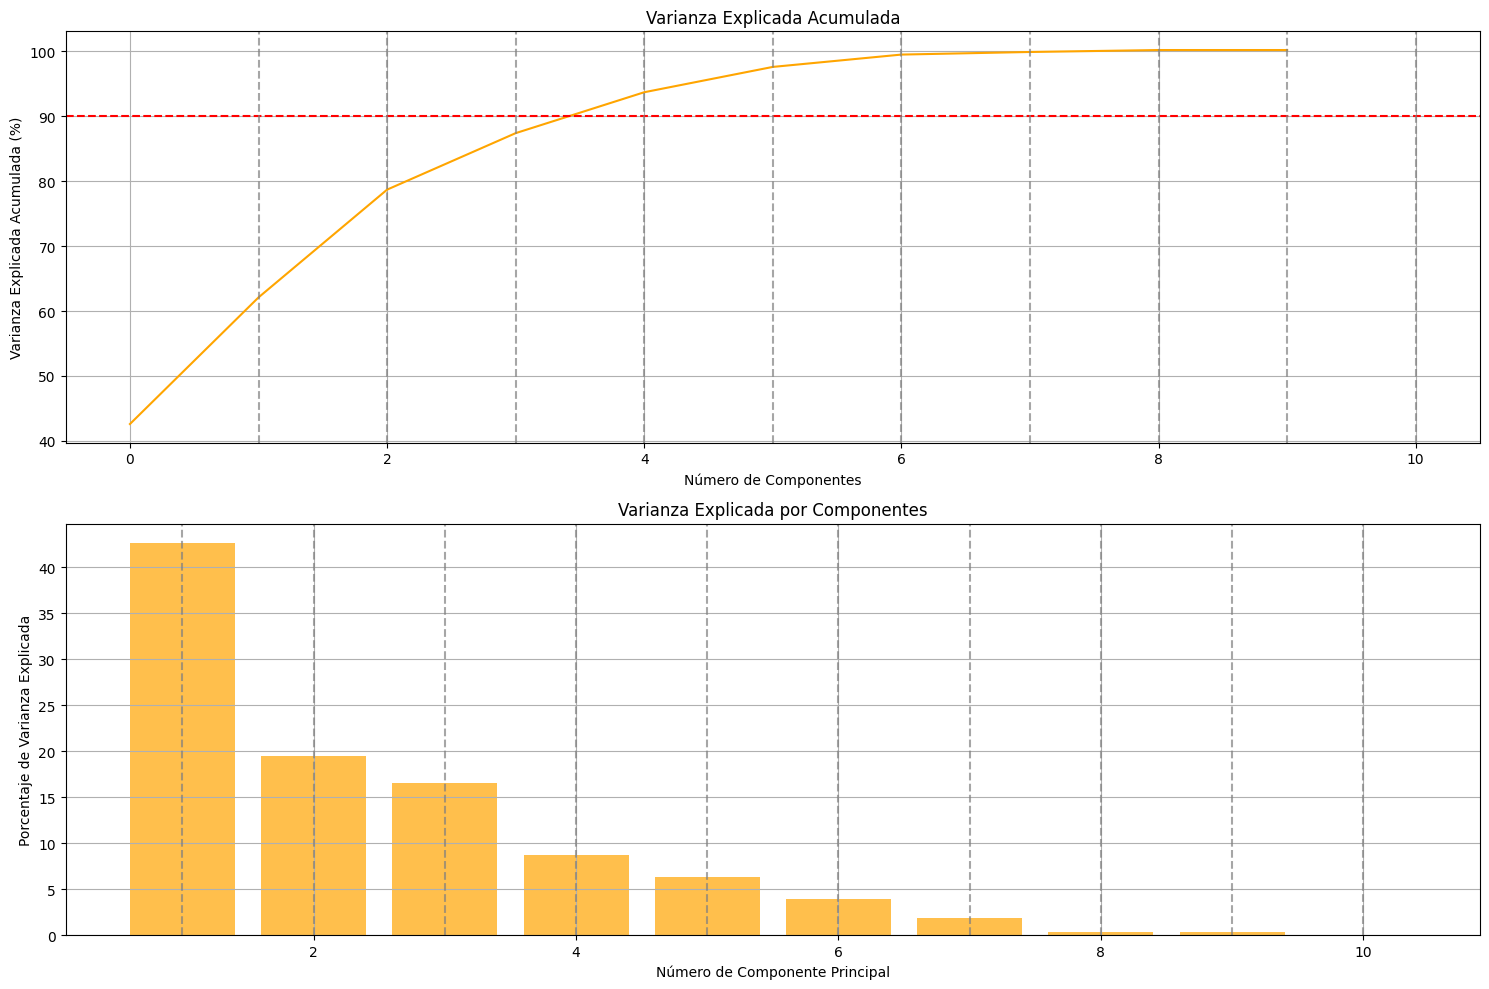

Varianza explicada por cada componente (%): [42.6 19.5 16.6  8.7  6.3  3.9  1.9  0.4  0.3  0. ]


,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6,Componente 7,Componente 8,Componente 9,Componente 10
0,42.6,62.1,78.7,87.4,93.7,97.6,99.5,99.9,100.2,100.2


In [69]:
# Vemos varianza acumulada en componentes principales
variance_ratio = km_m.view_pca_variance(scaled_df)

acc_var = km_m.calculate_accumulated_variance(variance_ratio)

display(acc_var)

Importancia caracteristicas

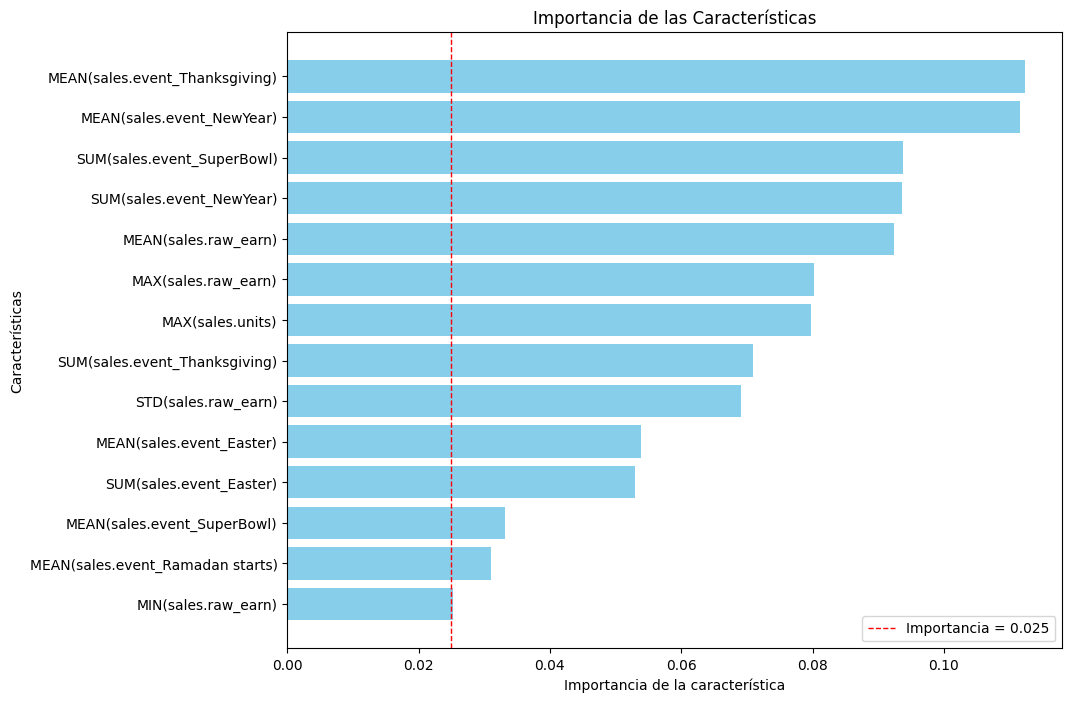

In [71]:
# Importancia de caracteristicas
# Preprocesamos datos
cluster_col='Cluster'
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([scaled_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.025
importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

# Seleccionamos solo las caracteristicas que tienen importancia por encima o igual del umbral
selected_features = importance_df[importance_df['Importance'] >= IMPORTANCE_THRES]

# Creamos una lista con las features más importantes usando la columna feature de importance_df
most_important_features = selected_features['Feature'].tolist()

# display(importance_df.head(10))

## Dimension Redux

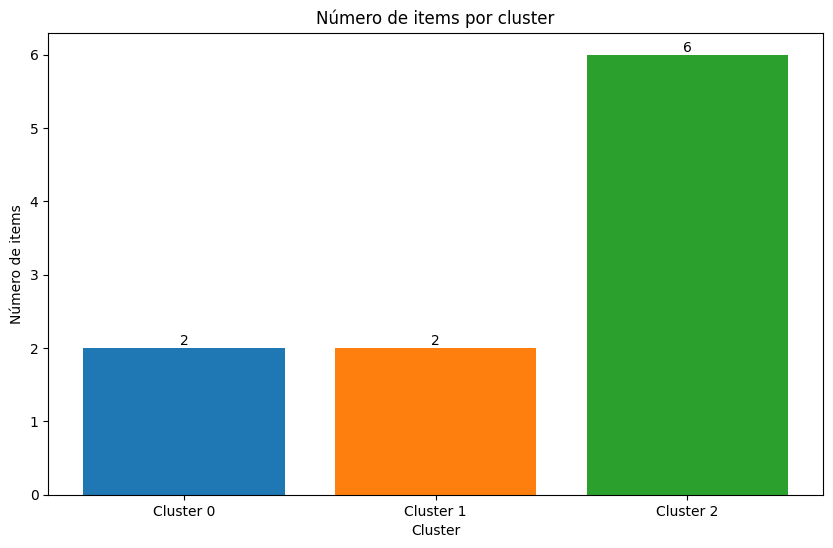

In [75]:
# Ejecutar PCA y clustering
n_components = 4 # Segun visto en varianza acumulada -> casi 90%

# Obtenemos scaled df con componentes y clusters
df_with_pca, loadings_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# # Mostrar el DataFrame con PCA y clustering
# display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

## Descripcion de los clusters

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

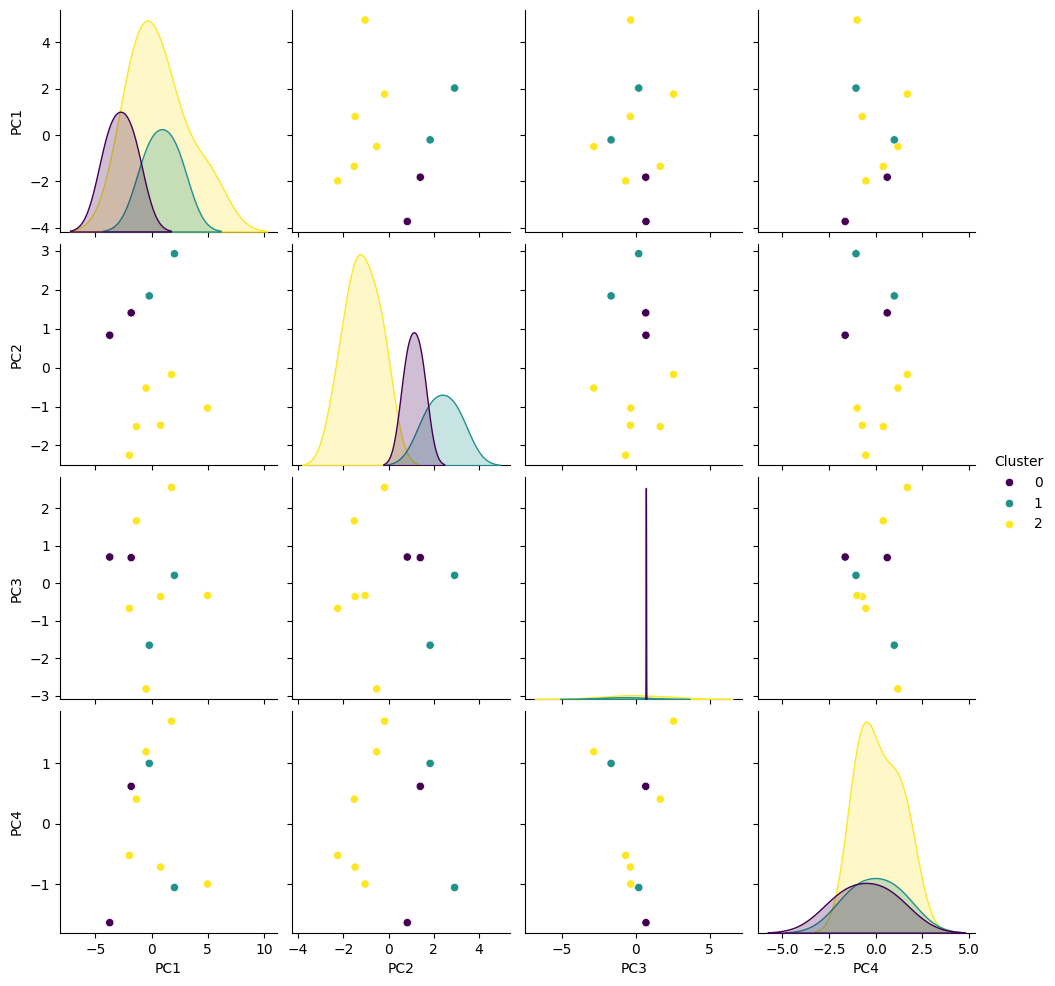

In [76]:
# Visualizacion clusters
cols = n_components + 1 # -> Seleccionamos solo las columnas de PC + Cluster
df_pairplot = df_with_pca.iloc[:, -(cols):]

df_pairplot['Cluster'] = df_with_pca['Cluster']
sns.pairplot(df_pairplot[0:], hue='Cluster', palette='viridis')

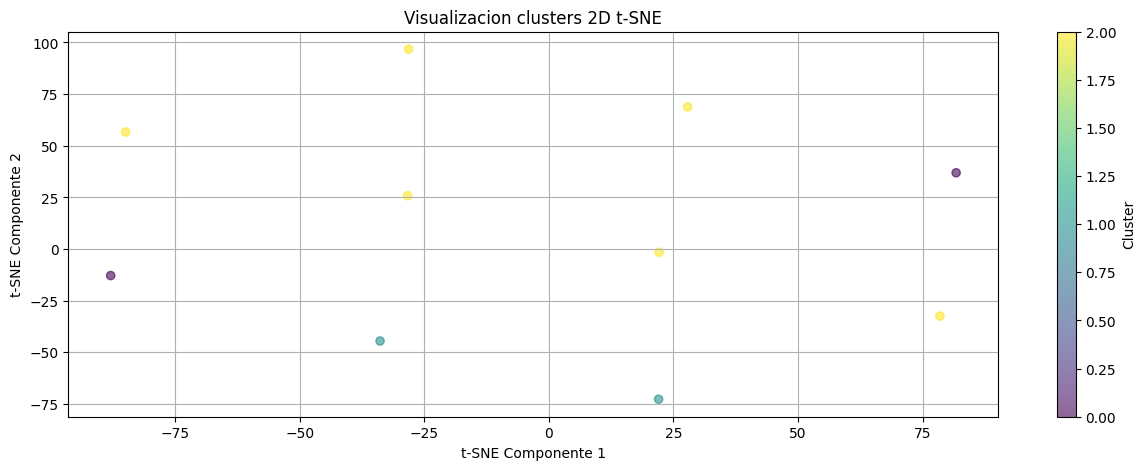

In [77]:
# T SNE visualizacion de clusters
km_m.tsne_visualization(df_pairplot, n_components=2, perplexity=9)

**Analisis**  
  
No parece muy acertado 4 optK.  
  
Mejora con 3 PC y 3 optK

Mostrar descripciones

In [78]:
# Seleccionamos las features según la lista most_important_features obtenida con random forest
importance_df_filt = importance_df[importance_df['Feature'].isin(most_important_features)]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
# Ordenamos columnas de description_df usando sort
description_df = description_df[sorted(description_df.columns)]
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,1,2
MEAN(sales.event_Thanksgiving),0.323798,0.961833,-0.341520
MEAN(sales.event_NewYear),-1.821688,0.621603,0.121063
SUM(sales.event_SuperBowl),-0.963724,0.134220,0.619105
SUM(sales.event_NewYear),-1.478448,-0.119253,0.659004
MEAN(sales.raw_earn),-0.925642,-0.053819,0.448514
MAX(sales.raw_earn),-0.647633,-0.023390,0.860911
MAX(sales.units),0.097859,1.889908,-0.587156
SUM(sales.event_Thanksgiving),-0.294227,0.677840,0.156425
STD(sales.raw_earn),-0.649649,0.073050,0.405406
MEAN(sales.event_Easter),-0.037284,1.221452,-0.052139


In [79]:
# Asignacion clusters a shops
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,2
1,NYC_2,New York,Harlem,2
2,NYC_3,New York,Tribeca,2
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,1


In [80]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Tiendas con baja influencia de eventos y rendimiento bajo',
        'description': 'Este grupo incluye tiendas cuyas ventas son poco influenciadas por eventos importantes como el Super Bowl, Thanksgiving o New Year. Estas tiendas tienen un rendimiento de ventas inferior, con bajos ingresos y una estabilidad moderada a baja en sus métricas de ventas.'
    },
    1: {
        'cluster_name': 'Tiendas con alta influencia de eventos específicos',
        'description': 'Las tiendas en este cluster muestran un alto impacto en ventas debido a eventos como Thanksgiving y Easter. Sus ventas suelen aumentar significativamente durante estos eventos, lo que las hace dependientes de fechas especiales para mejorar su rendimiento.'
    },
    2: {
        'cluster_name': 'Tiendas con ventas estables pero menor dependencia de eventos',
        'description': 'Este cluster representa tiendas con ventas relativamente estables y menos dependencia de eventos para aumentar sus ingresos. Aunque algunos eventos pueden generar incrementos moderados en ventas, su comportamiento es más estable a lo largo del año.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,Cluster,cluster_name,description
0,NYC_1,New York,Greenwich_Village,2,Tiendas con ventas estables pero menor depende...,Este cluster representa tiendas con ventas rel...
1,NYC_2,New York,Harlem,2,Tiendas con ventas estables pero menor depende...,Este cluster representa tiendas con ventas rel...
2,NYC_3,New York,Tribeca,2,Tiendas con ventas estables pero menor depende...,Este cluster representa tiendas con ventas rel...
3,NYC_4,New York,Brooklyn,0,Tiendas con baja influencia de eventos y rendi...,Este grupo incluye tiendas cuyas ventas son po...
4,BOS_1,Boston,South_End,1,Tiendas con alta influencia de eventos específ...,Las tiendas en este cluster muestran un alto i...


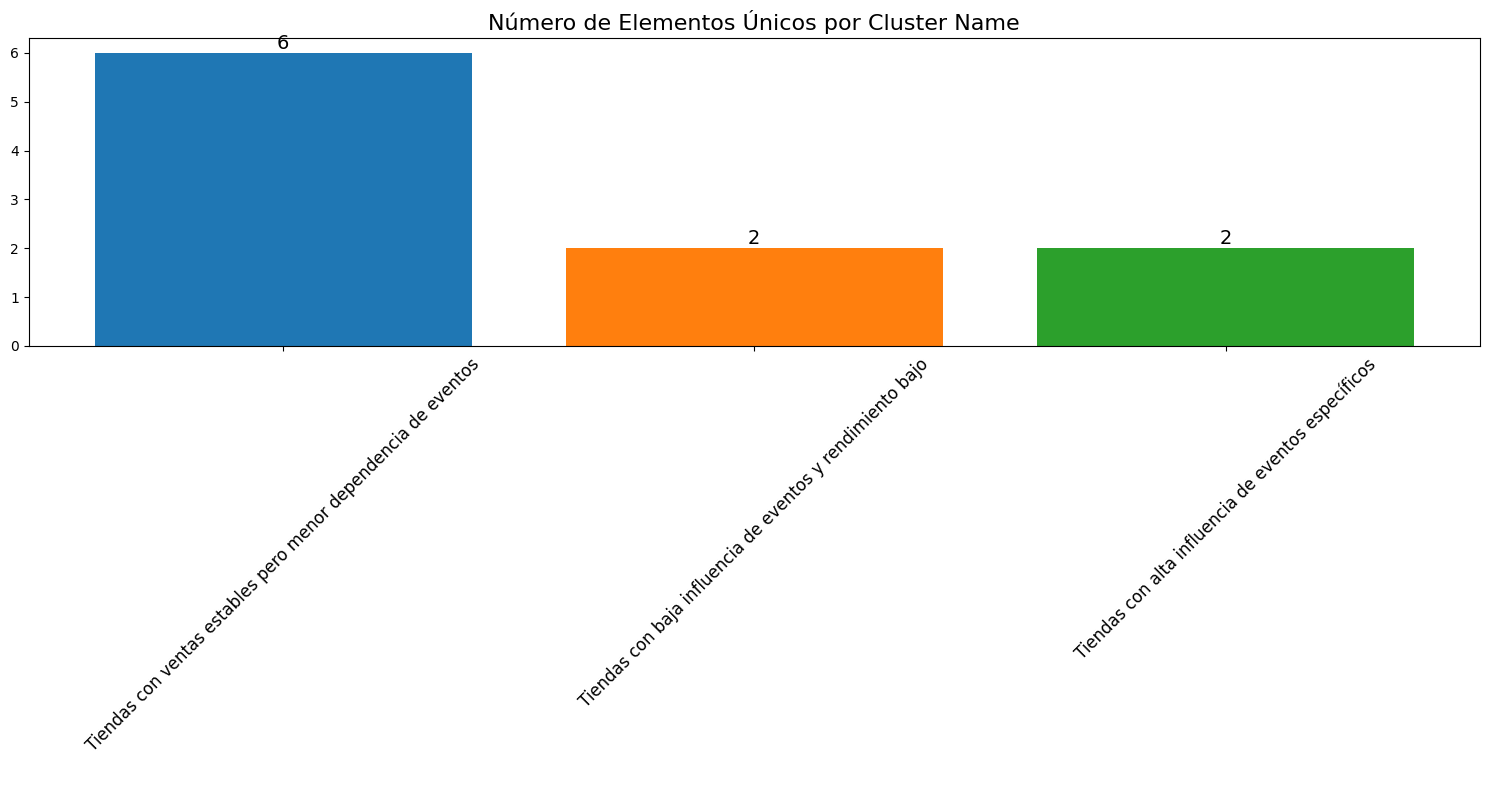

In [81]:
km_m.plot_clusters_with_name(shops_with_cluster_info)

## Guardamos csv

In [82]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_clusters_events_influence_sales.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
shops_with_cluster_info.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>